In [2]:
!apt update && apt install -y openslide-tools
!pip install openslide-python

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [773 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,898 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu j

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import time
from PIL import Image, ImageOps, ImageFilter
import random
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import os
import openslide


### Preparing Slides with the modified WSI Reader

Note: This is only needed for patches in which the X,Y position on the slide will be used.

In [2]:
from TIAToolbox_WSIReader_Modified import WSIReader

In [ ]:
from tiatoolbox.wsicore.wsireader import WSIReader

In [11]:
wsiReader = WSIReader.open(input_img='/content/02000664-00817020-23HI017402-8-H07-1.ndpi')
wsiReader.save_tiles(output_dir='/content/PatchOut', tile_objective_value=10, tile_read_size=(256,256))

### Preparing the Grid from WSIs without Masking

In [12]:
import os
import numpy as np
import PIL
from PIL import Image

def flood_fill_iterative(c, r, grid, mask):
    """Iterative flood fill for RGB grid using a stack."""
    stack = [(c, r)]
    rows, cols, _ = grid.shape

    while stack:
        x, y = stack.pop()
        if x < 0 or x >= cols or y < 0 or y >= rows or mask[y, x] or not np.all(grid[y, x] != [0,0,0]):
            continue

        mask[y, x] = True  # Mark this cell as visited

        # Add neighboring cells to stack
        stack.append((x + 1, y))
        stack.append((x - 1, y))
        stack.append((x, y + 1))
        stack.append((x, y - 1))

# pathToPatches assumes the the path has form: C:\\...\\...\\... and is a folder containing patches created using TIAToolbox
# patchSize assumes square patches and thus takes a single int as input

def stitchPatches(pathToPatches, patchSize, outputDir):

    fileName = pathToPatches.split("\\")[-1]
    slide = fileName.split("/")[-1]
    patch_files = [os.path.join(pathToPatches, file) for file in (os.listdir(pathToPatches)[3:]) if file.endswith('.jpg')]

    # Create a dict mapping each x,y coordinate to the given patches path
    # Additionally stores the maximum x and y coordinates to know the final size of the image
    max_x = 0
    max_y = 0
    for patch in patch_files:
        patchName = os.path.basename(patch).split(".")[0]
        if(patchName == "slide_thumbnail"):
          continue
        x, y = map(int, patchName.split("_")[-2:])
        max_x = max(max_x, x)
        max_y = max(max_y, y)

    stitched_img = np.empty((max_y + patchSize, max_x + patchSize, 3), dtype=np.uint8)

    # Creating the full array representing the original image
    for patch in patch_files:
        patchName = os.path.basename(patch).split(".")[0]
        if(patchName == "slide_thumbnail"):
          continue
        x, y = map(int, patchName.split("_")[-2:])
        with Image.open(patch) as img:
            patch_array = np.array(img)

            # Check the shape and pad if necessary
            if patch_array.shape != (patchSize, patchSize, 3):
                padded_patch = np.zeros((patchSize, patchSize, 3), dtype=np.uint8)
                padded_patch[:patch_array.shape[0], :patch_array.shape[1]] = patch_array
                patch_array = padded_patch

            stitched_img[y:y + patchSize, x:x + patchSize] = patch_array

  # Removing patches that can not link to the main object
    rows, cols, _ = stitched_img.shape
    mask = np.zeros((rows, cols), dtype=bool)

    # Assuming a central patch starts filled (not black)
    central_r, central_c = rows // 2, cols // 2

    # Start iterative flood fill from the center
    flood_fill_iterative(central_c, central_r, stitched_img, mask)

    # Blank out unconnected patches
    for r in range(rows):
        for c in range(cols):
            if not mask[r, c]:  # If not visited
                stitched_img[r, c] = [0, 0, 0]  # Set to black

    # Saving the final image
    im = Image.fromarray(stitched_img)
    outPath = os.path.join(outputDir, f"WSIMASK_{slide}.jpeg")
    im.save(outPath)

    del stitched_img  # Clear large objects explicitly
    return "All Images Have Been Created"


stitchPatches(pathToPatches='/content/PatchOut/02000664-00817020-23HI017402-8-H07-1.ndpi',
              patchSize=256, outputDir='/content/GridOut')

KeyboardInterrupt: 

# Extra Functions While Testing

In [11]:
!rm -r /content/PatchOut

# RL Agents

## Search Agent

In [18]:
# The search agent uses a ResNet34 for feature extraction
# Following this, features are passed through an LSTM before the final fully connected layer
# The FC layer of this model has an output size of 8, which maps to each of the 8 possible actions
# The agent is updated with Policy gradient

import torchvision

resnet = torchvision.models.resnet34(weights='DEFAULT')

SearchAgentBackbone = torch.nn.Sequential(*(list(resnet.children())[:-1]))
SearchAgentClassifier = torch.nn.Sequential(
    torch.nn.LSTM(input_size=512, hidden_size=512, num_layers=1, batch_first=True),
    torch.nn.Linear(64,8),
    torch.nn.Softmax(dim=1)
    )

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

##Decision Agent

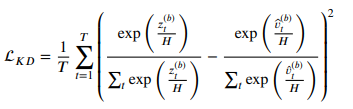

In [15]:
# The Decision Agent is a ResNet34 Model fitted with the required FC Layer
# In this case, we will be using the ImageNet pretrained weights in order to achieve adequate performance with fewer samples

# As in the paper, this agent is trained with the above AKD loss which integrates the teacher's information

import torchvision

DecisionAgent = torchvision.models.resnet34(weights='DEFAULT')
DecisionAgent.fc = torch.nn.Linear(DecisionAgent.fc.in_features, 2)

DecisionAgent


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  